In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from nltools.data import Brain_Data, Design_Matrix, Adjacency
import networkx as nx
from scipy import signal
from mne_connectivity import spectral_connectivity_epochs
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from itertools import cycle
from matplotlib.lines import Line2D
from scipy.fft import fft, fftfreq
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from matplotlib.animation import FuncAnimation, PillowWriter
import plotly.graph_objs as go
from functools import reduce
import teneto
from teneto import TemporalNetwork


from functions.EpiIndex import *
from functions.Connectivity import *

In [3]:
raw=mne.io.read_raw_fif('/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif', preload=True)
#Reading a npy file 
data_alpha = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_alpha_aec_dense.npy')
data_beta = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_beta_aec_dense.npy')
data_hgamma = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_high_gamma1_aec_dense.npy')
data_lgamma = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_low_gamma_aec_dense.npy')
data_theta = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_theta_aec_dense.npy')

data_alpha_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_alpha_aec_distance_dense.npy')
data_beta_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_beta_aec_distance_dense.npy')
data_hgamma_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_high_gamma1_aec_distance_dense.npy')
data_lgamma_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_low_gamma_aec_distance_dense.npy')
data_theta_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_theta_aec_distance_dense.npy')
# Reading the .tsv file 
xyz_loc = pd.read_csv('/home/pablo/works/dev_thesis_SEEG/data/pte_01/others/sEEG_locs_filtered.tsv', sep='\t')


#Data with other metrics
data_coh = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/SR_subseg_connectivity_data_high_freq_coh_dense.npy')[:,:,:,0]
# Assuming data is the array with shape (50, 127, 127)
for i in range(data_coh.shape[0]):
    # Extract the lower triangular part (including the diagonal)
    lower_triangular = np.tril(data_coh[i])
    
    # Mirror the lower triangular part to the upper triangular part
    data_coh[i] = lower_triangular + lower_triangular.T - np.diag(np.diag(lower_triangular))

#Make data_coh symmetric
#To know the index of the channels ["lp'11", "lp'12", "op'12", "pi'18", "pa'12"] in the raw object into an array
idx_channels = [raw.ch_names.index(ch) for ch in ["lp'11", "lp'12", "op'12", "pi'18", "pa'12"]]
#Eliminate from data_coh the channels that are not in the raw object
data_coh = np.delete(data_coh, idx_channels, axis=1)
data_coh = np.delete(data_coh, idx_channels, axis=2)
# con_data=np.mean(data,axis=3)
raw.drop_channels(["lp'11", "lp'12", "op'12", "pi'18", "pa'12"])


inside_channels=["m'3","sc'3","sc'4","sc'5","sc'6","y'4","y'5","y'6","y'7","y'8","y'9"]
#Get the channels outside the SOZ 
outside_channels=[ch for ch in raw.ch_names if ch not in inside_channels]


Opening raw data file /home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif...
Isotrak not found
    Range : 4681728 ... 4866048 =   9144.000 ...  9504.000 secs
Ready.
Reading 0 ... 184320  =      0.000 ...   360.000 secs...


/tmp/ipykernel_8998/3813832574.py:1: RuntimeWarning: This filename (/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw=mne.io.read_raw_fif('/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif', preload=True)


In [4]:
data=data_lgamma
data=data.transpose(1,2,0)
tnet_bu= TemporalNetwork(N=data.shape[0],T=data.shape[2],nettype='wu',from_array=data,
                      timetype='discrete',timeunit='epoch', nodelabels=list(xyz_loc['formatted_label'].values))

tnet_bu.binarize(threshold_type='percent',threshold_level=0.10)

tnet_wu=TemporalNetwork(N=data.shape[0],T=data.shape[2],nettype='wu',from_array=data,
                      timetype='discrete',timeunit='epoch', nodelabels=list(xyz_loc['formatted_label'].values))

tnet_bu_ar=tnet_bu.network
communities_dict={}
k=2
algorithm='k_clique_communities'

for i in range(tnet_bu_ar.shape[2]):
    #Building a network using adjacency matrix
    adj = Adjacency(tnet_bu_ar[:,:,i],labels=raw.ch_names)
    
    G = nx.Graph(adj.to_graph())
    #Community detection algorithm 
    if algorithm=='girvan_newman':
        communities_generator=nx.community.girvan_newman(G)
        next_level_communities = next(communities_generator)
        communities = sorted(map(sorted, next_level_communities))
    elif algorithm=='edge_current_flow_betweenness_partition':
        communities_generator=nx.community.edge_current_flow_betweenness_partition(G, number_of_sets=k)
        communities=[list(c) for c in communities_generator]
    elif algorithm=='edge_betweenness_partition':
        communities_generator=nx.community.edge_betweenness_partition(G, number_of_sets=k)
        communities=[list(c) for c in communities_generator]
    elif algorithm=='k_clique_communities':
        communities_generator=list(nx.community.k_clique_communities(G,k))
        communities=[list(c) for c in communities_generator]
    elif algorithm=='greedy_modularity_communities':
        communities_generator=nx.community.greedy_modularity_communities(G)
        communities=[list(c) for c in communities_generator]
    elif algorithm=='naive_greedy_modularity_communities': 
        communities_generator=nx.community.naive_greedy_modularity_communities(G)
        communities=[list(c) for c in communities_generator]
    elif algorithm=='fast_label_propagation_communities':
        communities_generator=nx.community.fast_label_propagation_communities(G)
        communities=[list(c) for c in communities_generator]
    elif algorithm=='louvain_communities':
        communities_generator=nx.community.louvain_communities(G)
        communities=[list(c) for c in communities_generator]
    elif algorithm=='asyn_fluidc':
        #this algorithm only works for undirected and completely connected graphs
        communities_generator=nx.community.asyn_fluidc(G,k)
        communities=[list(c) for c in communities_generator]
    elif algorithm=='kernighan_lin_bisection':
        communities = [list(nx.community.kernighan_lin_bisection(G)[0])]
        communities.append(list(nx.community.kernighan_lin_bisection(G)[1]))
    communities_dict[i]=communities

# Number of time steps
num_timesteps = len(communities_dict)

# Number of channels
num_channels = len(raw.ch_names)

# Initialize an array for each time step (2D list) with default value -1 (indicating no community yet)
output = [[-1 for _ in range(num_timesteps)] for _ in range(num_channels)]

# Iterate through the communities dictionary
for t, subcommunities in communities_dict.items():
    # Loop through each subcommunity and assign its index to the respective channels
    for subcom_idx, subcommunity in enumerate(subcommunities):
        for channel in subcommunity:
            # Find the index of the channel in ch_names
            if channel in raw.ch_names:
                channel_idx = raw.ch_names.index(channel)
                # Assign the subcommunity index to the correct channel
                output[channel_idx][t] = subcom_idx

#Making temporal consensus
communities_after=teneto.communitydetection.make_temporal_consensus(output)

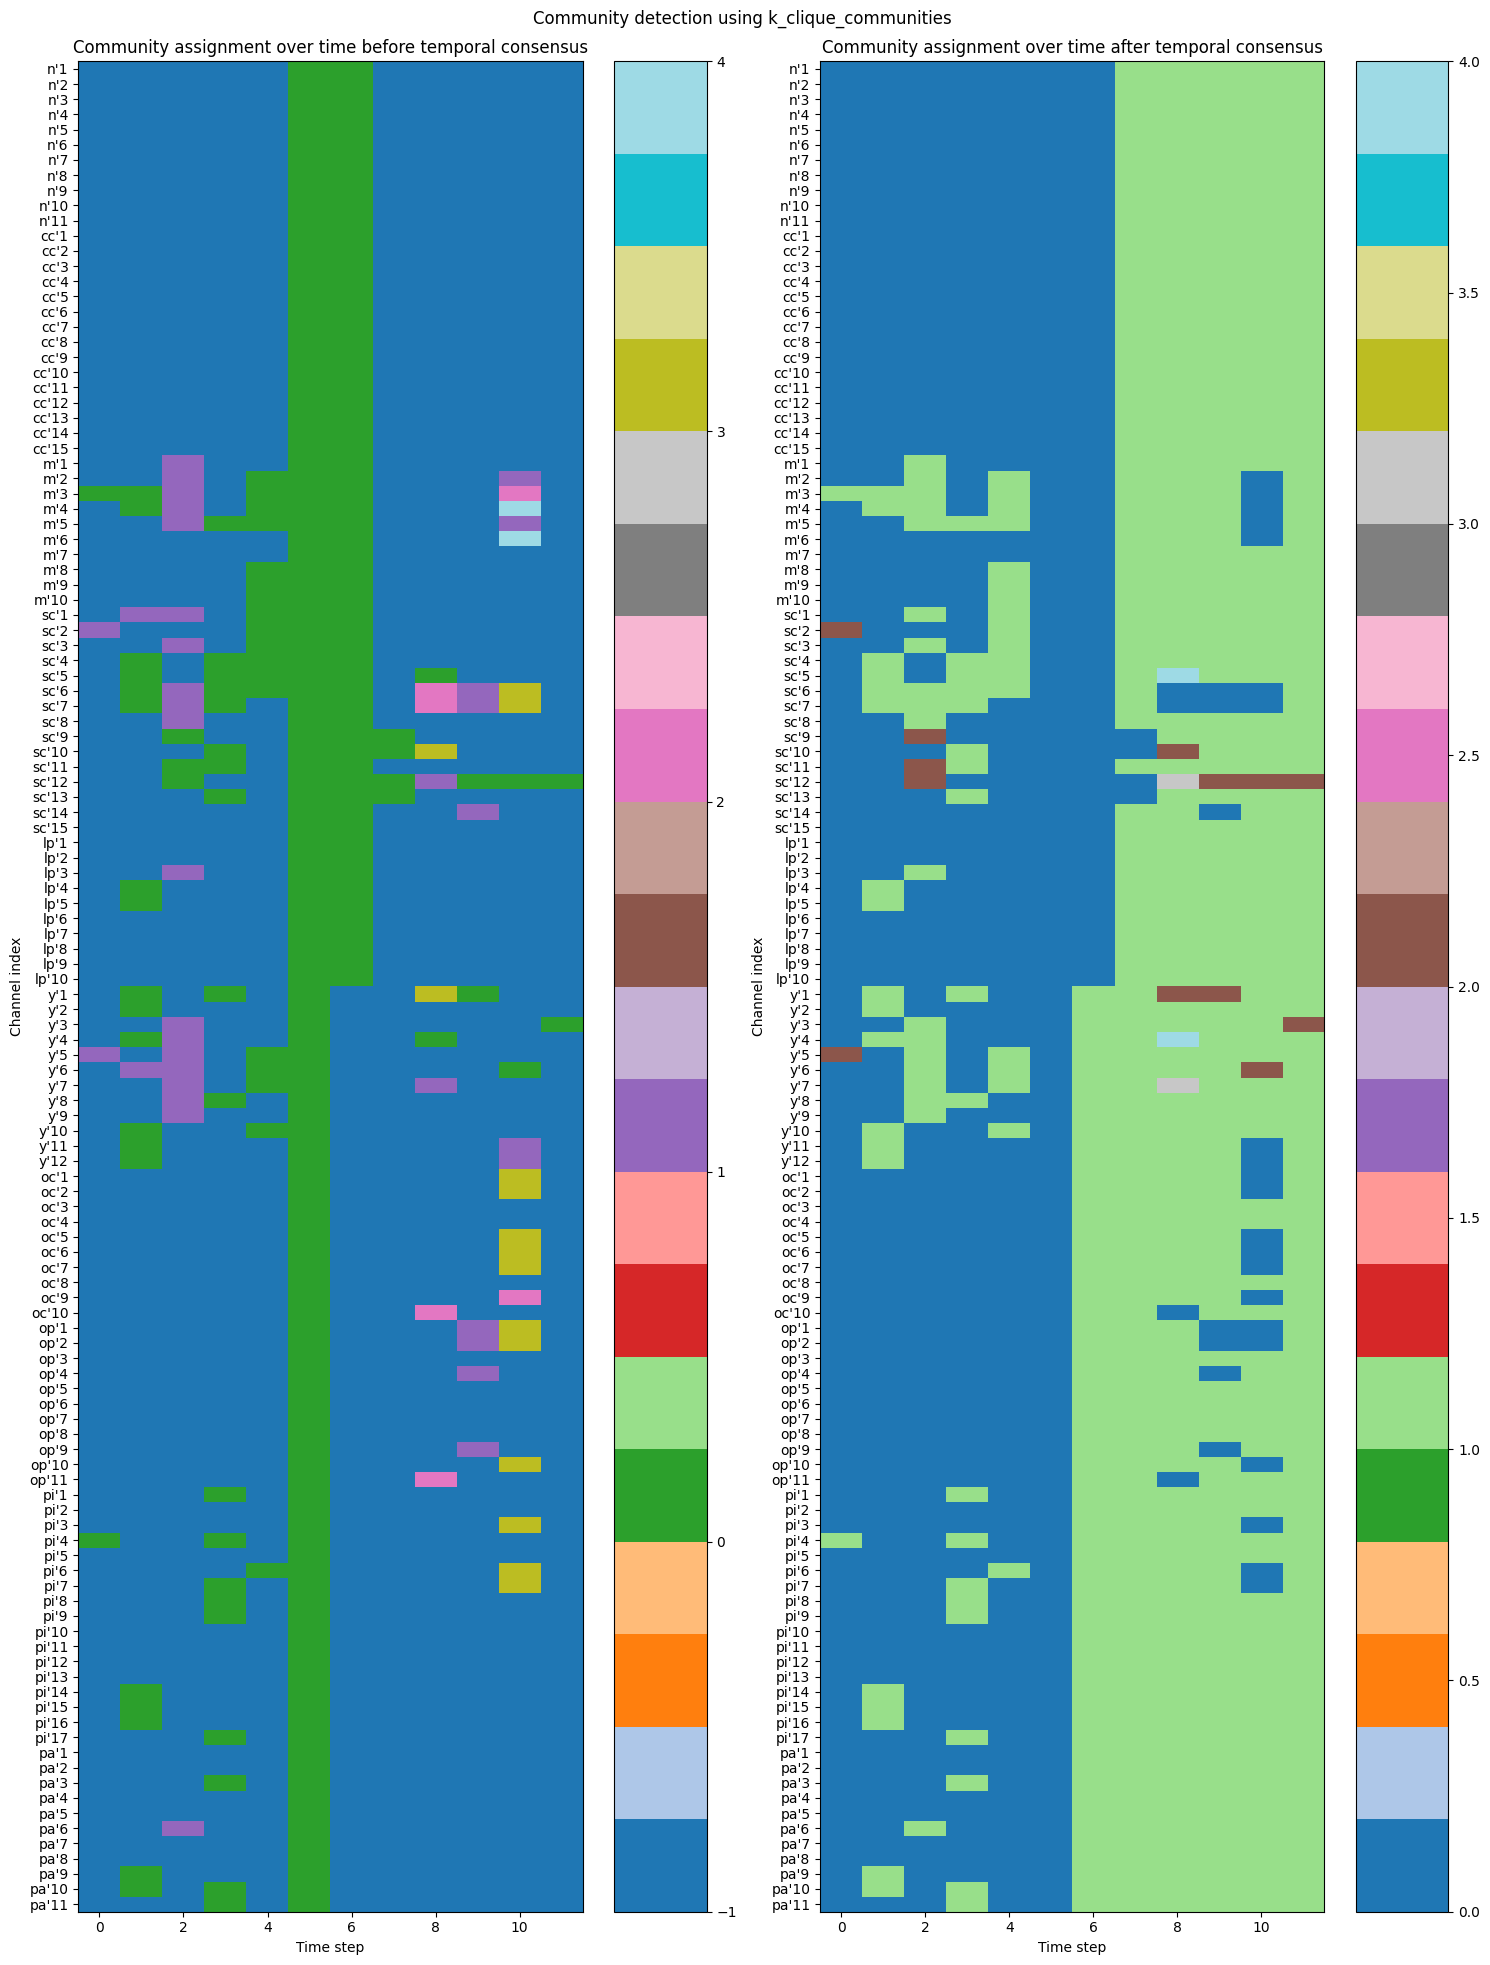

In [5]:
#Compare the communities
fig, axes = plt.subplots(1, 2, figsize=(15, 20))

# Plot for 'Community assignment over time before temporal consensus'
im1 = axes[0].imshow(output, aspect='auto', cmap='tab20')
axes[0].set_xlabel('Time step')
axes[0].set_ylabel('Channel index')
axes[0].set_title('Community assignment over time before temporal consensus')
axes[0].set_yticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1))
axes[0].set_yticklabels(xyz_loc['formatted_label'].values)
fig.colorbar(im1, ax=axes[0])

# Plot for 'Community assignment over time after temporal consensus'
im2 = axes[1].imshow(communities_after, aspect='auto', cmap='tab20')
axes[1].set_xlabel('Time step')
axes[1].set_ylabel('Channel index')
axes[1].set_title('Community assignment over time after temporal consensus')
axes[1].set_yticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1))
axes[1].set_yticklabels(xyz_loc['formatted_label'].values)
fig.colorbar(im2, ax=axes[1])

plt.suptitle(f'Community detection using {algorithm} \n')


plt.tight_layout()
plt.show()

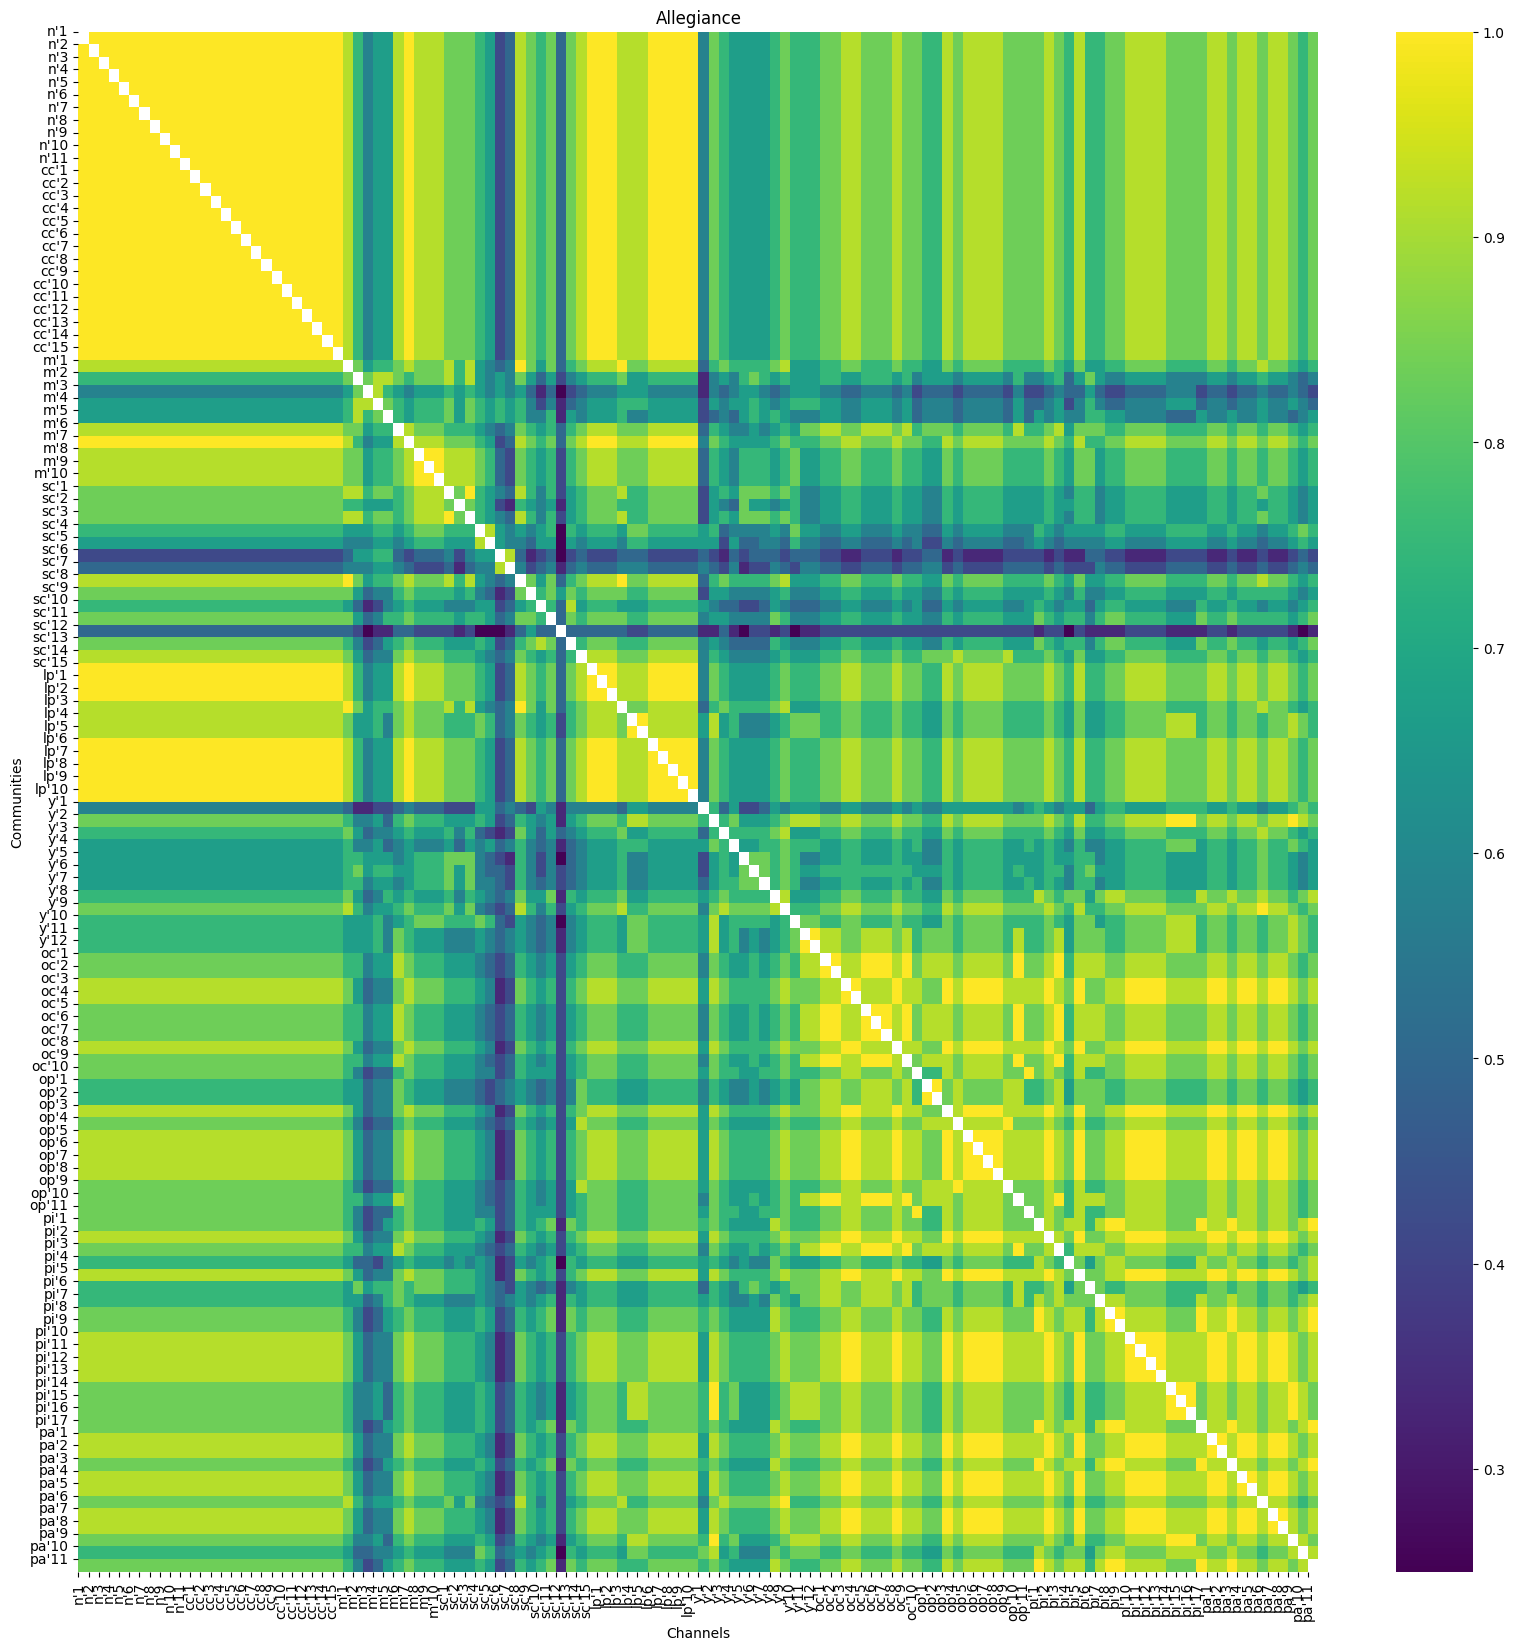

In [6]:
allegiance_m=teneto.communitymeasures.allegiance(communities_after)
plt.figure(figsize=(20,20))
sns.heatmap(allegiance_m,cmap='viridis')
plt.title('Allegiance')
plt.xlabel('Channels')
plt.ylabel('Communities')
plt.yticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1), xyz_loc['formatted_label'].values)
plt.xticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1), xyz_loc['formatted_label'].values)
plt.show()

In [7]:
#Rebuilding the communities for each time step
communities_dict_after={}
for t in range(len(communities_after[0])):
    temp_com={}
    for i, ch in enumerate(raw.ch_names):
        temp_com[communities_after[i][t]]=temp_com.get(communities_after[i][t],[])+[ch]
    communities_dict_after[t]=temp_com       


In [8]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [9]:
#WE are going to extrac the Jaccard index for each community in each time step
#Comparing with the inside channels
jaccard_index={}
for t in range(len(communities_dict_after)):
    temp_jaccard={}
    for com in communities_dict_after[t]:
        temp_jaccard[com]=jaccard_similarity(inside_channels,communities_dict_after[t][com])
    jaccard_index[t]=temp_jaccard

In [10]:
#Get the maximum for each time step, and the community channels that belong to it 
max_jaccard=[]
max_jaccard_com=[]
for t in range(len(jaccard_index)):
    max_jaccard.append(max(jaccard_index[t].values()))
    max_jaccard_com.append(max(jaccard_index[t], key=jaccard_index[t].get))

In [11]:
max_jaccard_com

[1, 1, 1, 1, 1, 0, 1, 1, 4, 1, 2, 1]

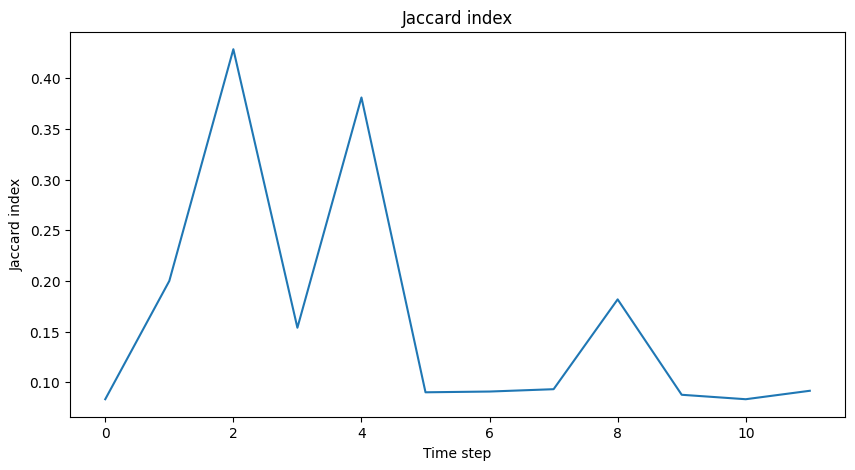

In [12]:
#Plotting max_jaccard   
plt.figure(figsize=(10,5))
plt.plot(max_jaccard)
plt.title('Jaccard index')
plt.xlabel('Time step')
plt.ylabel('Jaccard index')
plt.show()

In [13]:
#printing the communities of maximum jaccard index
dict_communities={}
for t in range(len(communities_dict_after)):
    print(f'Time step {t}: {communities_dict_after[t][max_jaccard_com[t]]}')
    dict_communities[t]=communities_dict_after[t][max_jaccard_com[t]]

print('The inside channels are:',inside_channels)

Time step 0: ["m'3", "pi'4"]
Time step 1: ["m'3", "m'4", "sc'4", "sc'5", "sc'6", "sc'7", "lp'4", "lp'5", "y'1", "y'2", "y'4", "y'10", "y'11", "y'12", "pi'14", "pi'15", "pi'16", "pa'9", "pa'10"]
Time step 2: ["m'1", "m'2", "m'3", "m'4", "m'5", "sc'1", "sc'3", "sc'6", "sc'7", "sc'8", "lp'3", "y'3", "y'4", "y'5", "y'6", "y'7", "y'8", "y'9", "pa'6"]
Time step 3: ["m'5", "sc'4", "sc'5", "sc'6", "sc'7", "sc'10", "sc'11", "sc'13", "y'1", "y'8", "pi'1", "pi'4", "pi'7", "pi'8", "pi'9", "pi'17", "pa'3", "pa'10", "pa'11"]
Time step 4: ["m'2", "m'3", "m'4", "m'5", "m'8", "m'9", "m'10", "sc'1", "sc'2", "sc'3", "sc'4", "sc'5", "sc'6", "y'5", "y'6", "y'7", "y'10", "pi'6"]
Time step 5: ["n'1", "n'2", "n'3", "n'4", "n'5", "n'6", "n'7", "n'8", "n'9", "n'10", "n'11", "cc'1", "cc'2", "cc'3", "cc'4", "cc'5", "cc'6", "cc'7", "cc'8", "cc'9", "cc'10", "cc'11", "cc'12", "cc'13", "cc'14", "cc'15", "m'1", "m'2", "m'3", "m'4", "m'5", "m'6", "m'7", "m'8", "m'9", "m'10", "sc'1", "sc'2", "sc'3", "sc'4", "sc'5", "sc'

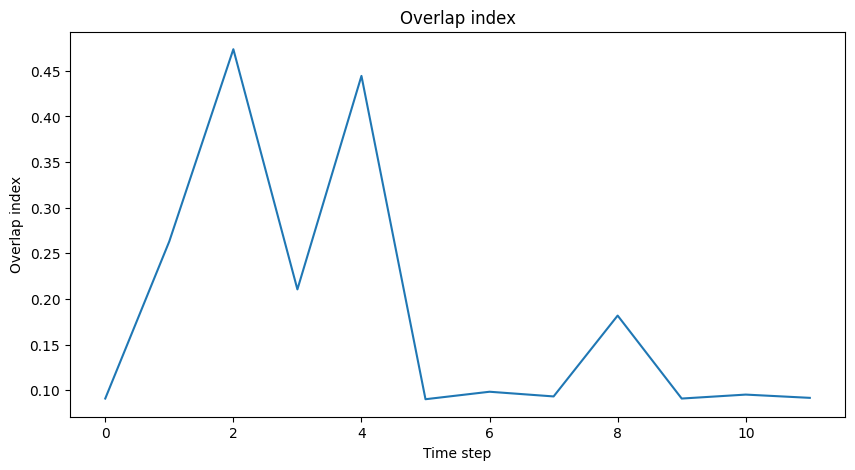

Time step 0: ["m'3", "pi'4"]
Time step 1: ["m'3", "m'4", "sc'4", "sc'5", "sc'6", "sc'7", "lp'4", "lp'5", "y'1", "y'2", "y'4", "y'10", "y'11", "y'12", "pi'14", "pi'15", "pi'16", "pa'9", "pa'10"]
Time step 2: ["m'1", "m'2", "m'3", "m'4", "m'5", "sc'1", "sc'3", "sc'6", "sc'7", "sc'8", "lp'3", "y'3", "y'4", "y'5", "y'6", "y'7", "y'8", "y'9", "pa'6"]
Time step 3: ["m'5", "sc'4", "sc'5", "sc'6", "sc'7", "sc'10", "sc'11", "sc'13", "y'1", "y'8", "pi'1", "pi'4", "pi'7", "pi'8", "pi'9", "pi'17", "pa'3", "pa'10", "pa'11"]
Time step 4: ["m'2", "m'3", "m'4", "m'5", "m'8", "m'9", "m'10", "sc'1", "sc'2", "sc'3", "sc'4", "sc'5", "sc'6", "y'5", "y'6", "y'7", "y'10", "pi'6"]
Time step 5: ["n'1", "n'2", "n'3", "n'4", "n'5", "n'6", "n'7", "n'8", "n'9", "n'10", "n'11", "cc'1", "cc'2", "cc'3", "cc'4", "cc'5", "cc'6", "cc'7", "cc'8", "cc'9", "cc'10", "cc'11", "cc'12", "cc'13", "cc'14", "cc'15", "m'1", "m'2", "m'3", "m'4", "m'5", "m'6", "m'7", "m'8", "m'9", "m'10", "sc'1", "sc'2", "sc'3", "sc'4", "sc'5", "sc'

In [15]:
## Other similarity metrics
# Overlap 
overlap_index={}
for t in range(len(communities_dict_after)):
    temp_overlap={}
    for com in communities_dict_after[t]:
        temp_overlap[com]=len(set(inside_channels).intersection(communities_dict_after[t][com])) / max(len(inside_channels),len(communities_dict_after[t][com]))
    overlap_index[t]=temp_overlap

#Get the maximum for each time step, and the community channels that belong to it
max_overlap=[]
max_overlap_com=[]
for t in range(len(overlap_index)):
    max_overlap.append(max(overlap_index[t].values()))
    max_overlap_com.append(max(overlap_index[t], key=overlap_index[t].get))

#Plotting max_overlap
plt.figure(figsize=(10,5))
plt.plot(max_overlap)
plt.title('Overlap index')
plt.xlabel('Time step')
plt.ylabel('Overlap index')
plt.show()

#printing the communities of maximum overlap index
for t in range(len(communities_dict_after)):
    print(f'Time step {t}: {communities_dict_after[t][max_overlap_com[t]]}')

print('The inside channels are:',inside_channels)


### For making the method even more unsupervised, we are going to analyze the communities generated at every timestep 

In [34]:
adj = Adjacency(tnet_bu_ar[:,:,2],labels=raw.ch_names)

<bound method Adjacency.shape of nltools.data.adjacency.Adjacency(shape=(7381,), square_shape=(122, 122), Y=(0, 0), is_symmetric=True,matrix_type=distance)>

In [101]:
com_2=communities_dict_after[2]
#Extract the adjacency matrix for each community
adj_com={}
for com, ch in com_2.items():
    com_idx=[raw.ch_names.index(chh) for chh in ch]
    adj_com[com]=Adjacency(tnet_bu_ar[com_idx][:,com_idx,2],labels=ch)

#Make it a graph
G = nx.Graph(adj_com[2].to_graph())
#Compute the eigenvector centrality and the betweenness centrality
eigenvector_centrality = nx.katz_centrality_numpy(G)
betweenness_centrality = nx.betweenness_centrality(G)


In [126]:
communities_dict_after.keys()


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [106]:
nx.radius(nx.Graph(adj_com[1].to_graph()))

4

In [224]:
import networkx as nx

# Function to calculate conductance of a community
def conductance(G, community):
    """
    Calculate the conductance of a single community in a graph G.

    Parameters:
    - G: The graph (networkx.Graph)
    - community: A set of nodes representing the community

    Returns:
    - conductance_score: The conductance of the community
    """
    # Convert the community set to a list
    community = set(community)
    
    # Compute the number of edges between the community and the rest of the graph (cut size)
    cut_size = nx.cut_size(G, community)
    print('The cut size is:',cut_size)
    
    # Compute the volume of the community (sum of degrees of the nodes inside the community)
    community_volume = sum(G.degree(n) for n in community)
    print('The community volume is:',community_volume)
    
    # Compute the volume of the rest of the graph
    outside_volume = sum(G.degree(n) for n in set(G.nodes()) - community)
    print('The outside volume is:',outside_volume)
    
    # Calculate the conductance score
    conductance_score = cut_size / (min(community_volume, outside_volume))
    print('The conductance score is:',conductance_score)
    
    return conductance_score

def normalized_cut(G, community):
    """
    Calculate the normalized cut for a single community in a graph G.

    Parameters:
    - G: The graph (networkx.Graph)
    - community: A set of nodes representing the community

    Returns:
    - normalized_cut_score: The normalized cut value of the community
    """
    # Convert the community set to a set for better performance
    community = set(community)
    
    # Compute the number of edges between the community and the rest of the graph (cut size)
    cut_size = nx.cut_size(G, community)
    
    # Compute the volume of the community (sum of degrees of nodes inside the community)
    community_volume = sum(G.degree(n) for n in community)
    
    # Compute the volume of the rest of the graph (sum of degrees of nodes outside the community)
    outside_community = set(G.nodes()) - community
    outside_volume = sum(G.degree(n) for n in outside_community)
    
    # Avoid division by zero by checking volumes
    if community_volume == 0 or outside_volume == 0:
        return float('inf')  # Return a large value if one of the volumes is zero (invalid cut)
    
    # Calculate normalized cut
    normalized_cut_score = (cut_size / community_volume) + (cut_size / outside_volume)
    
    return normalized_cut_score


import networkx as nx
from itertools import combinations

def intra_community_density_with_size_regularization(G, community, alpha=0.2, size_threshold=15):
    """
    Calculate the intra-community density with size regularization for a community in a graph.

    Parameters:
    - G: The graph (networkx.Graph)
    - community: A set of nodes representing the community
    - alpha: Regularization factor to penalize large or small communities (default: 0.1)
    - size_threshold: The ideal size of the community (default: 10)

    Returns:
    - density_score: The intra-community density with regularization
    """
    community = set(community)
    num_nodes = len(community)
    
    if num_nodes <= 3:
        return 0  # If the community is too small, return density as 0

    # Count edges within the community
    intra_edges = G.subgraph(community).number_of_edges()

    # Calculate intra-community density
    possible_edges = num_nodes * (num_nodes - 1) / 2
    if possible_edges == 0:
        density = 0
    else:
        density = intra_edges / possible_edges
    
    # Size regularization: penalize communities that are too small or too large
    size_penalty = alpha * abs(num_nodes - size_threshold) / size_threshold

    # Regularized density score
    density_score = density - size_penalty
    
    return max(0, density_score)  # Ensure non-negative density score

t=10
com_2=communities_dict_after[t]

# Function to calculate conductance of all communities
adj = Adjacency(tnet_bu_ar[:,:,t],labels=raw.ch_names)
G = nx.Graph(adj.to_graph())

conductance_scores = {}
for com, ch in com_2.items():
    # com_idx=[raw.ch_names.index(chh) for chh in ch]
    # adj_com=Adjacency(tnet_bu_ar[com_idx][:,com_idx,t],labels=ch)
    # G = nx.Graph(adj_com.to_graph())
    print('The community is:',ch)
    conductance_scores[com] = intra_community_density_with_size_regularization(G, ch)

print(conductance_scores)


The community is: ["n'1", "n'2", "n'3", "n'4", "n'5", "n'6", "n'7", "n'8", "n'9", "n'10", "n'11", "cc'1", "cc'2", "cc'3", "cc'4", "cc'5", "cc'6", "cc'7", "cc'8", "cc'9", "cc'10", "cc'11", "cc'12", "cc'13", "cc'14", "cc'15", "m'1", "m'7", "m'8", "m'9", "m'10", "sc'1", "sc'2", "sc'3", "sc'4", "sc'5", "sc'8", "sc'9", "sc'10", "sc'11", "sc'13", "sc'14", "sc'15", "lp'1", "lp'2", "lp'3", "lp'4", "lp'5", "lp'6", "lp'7", "lp'8", "lp'9", "lp'10", "y'1", "y'2", "y'3", "y'4", "y'5", "y'7", "y'8", "y'9", "y'10", "oc'3", "oc'4", "oc'8", "oc'10", "op'3", "op'4", "op'5", "op'6", "op'7", "op'8", "op'9", "op'11", "pi'1", "pi'2", "pi'4", "pi'5", "pi'8", "pi'9", "pi'10", "pi'11", "pi'12", "pi'13", "pi'14", "pi'15", "pi'16", "pi'17", "pa'1", "pa'2", "pa'3", "pa'4", "pa'5", "pa'6", "pa'7", "pa'8", "pa'9", "pa'10", "pa'11"]
The community is: ["m'2", "m'3", "m'4", "m'5", "m'6", "sc'6", "sc'7", "y'11", "y'12", "oc'1", "oc'2", "oc'5", "oc'6", "oc'7", "oc'9", "op'1", "op'2", "op'10", "pi'3", "pi'6", "pi'7"]
The

In [162]:
sum(G.degree(n) for n in set(G.nodes()) - set(com_2[1]))

3488

In [145]:
G.nodes

NodeView(("sc'9", "sc'11", "sc'12"))